In [1]:
# !pip install laspy
# !pip install geopandas

In [2]:
# !pip install sqlalchemy psycopg2
#!pip install psycopg2-binary

In [3]:
!pip install boto3

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import boto3
import json

In [5]:
import numpy as np
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib as plt

%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Visualize some raw LIDAR data, and start correlating the LIDAR data to the true height of the buildings

List some of the questions we need to answer
1. What is the LIDAR-Z? Is it the z above sea level? I.e. Does the Z change with the height of the ground.
2. What is the accuracy of LIDAR x and y reading, Can LIDAR readings nominally be within the permeter of the building be of height that is clearly not within reasonable range of a height of such building
3. Visualize LiDAR reading of some buildings, i.e. Smithonian musuem, some houses, etc, and compare it to the actual reading and see if helps.  
 

## Develop a routine to visualize LIDAR readings in and around a building 

1. Use Smithsonian National Museum of Natural History, coordinate (38.8913° N, 77.0261° W). 
2. Get the building information from the buildinginfotest table  

In [6]:
#Need to get this instance's public address
!curl 'https://api.ipify.org?format=json'

{"ip":"34.236.18.197"}

In [7]:
#Get information from Secrets Manager, especially about the database
secretsmanager_client = boto3.client('secretsmanager')
dbSecretValues = secretsmanager_client.get_secret_value(SecretId='Postgres-GISDB')

In [8]:
dbSecretValuesJson = json.loads(dbSecretValues['SecretString'])
#uncomment the following line to confirm the Database access information
#dbSecretValuesJson 

In [9]:
from sqlalchemy import create_engine
# Postgres username, password, and database name
POSTGRES_ADDRESS = dbSecretValuesJson['POSTGRES_ADDRESS'] ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = int(dbSecretValuesJson['POSTGRES_PORT'])
POSTGRES_USERNAME = dbSecretValuesJson['POSTGRES_USERNAME'] ## CHANGE THIS TO YOUR PANOPLY/POSTGRES USERNAME
POSTGRES_PASSWORD = dbSecretValuesJson['POSTGRES_PASSWORD'] ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD POSTGRES_DBNAME = 'database' ## CHANGE THIS TO YOUR DATABASE NAME
POSTGRES_DBNAME = dbSecretValuesJson['POSTGRES_DBNAME']
# A long string that contains the necessary Postgres login information
# postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(
#     username=POSTGRES_USERNAME,
#     password=POSTGRES_PASSWORD,
#     ipaddress=POSTGRES_ADDRESS,
#     port=POSTGRES_PORT,
#     dbname=POSTGRES_DBNAME))
postgres_str = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}/{POSTGRES_DBNAME}"

cnx = create_engine(postgres_str)

### Get the building infromation associated with Smithonian National Museum of Natural History

Access the GIS database to get basic information on that building

Smithsonian National Museum of Natural History, coordinate (38.8913° N, 77.0261° W)

The ALTITUDE_M field in original geojson file or the altitude_m field in the GIS database is the actual "true" height according the ground survey, we will it as the ground truth, as use LIDAR data to estimate this height 

Library of Congress : 38.8887° N, 77.0047 (another building candidate)

In [10]:
pd.read_sql_query('''select * from buildinginfotest where
ST_WITHIN ('POINT(-77.0261 38.8913 7.22)'::geometry, buildinginfotest.border)''', cnx)

,id,egid,shape_area,altitude_m,rooftype,shape_length,border,estimated_height
0,75888,DC00005298,21689.577757,53.61,Default,821.300506,0106000000010000000103000000030000002D0000007F...,None


from this query result, you can see the altitude_m for the musuem is 53.61 meters

Let's collect some LIDAR data both inside the building perimeter and around the building, by using the EGID code

In [11]:
natural_hist_museum_lidar_readings = pd.read_sql_query('''select * from lidarbuildingmatchtest where
    bldgid = 75888''', cnx)

In [12]:
natural_hist_museum_lidar_readings.drop(columns = ['border', 'las_grnd_coord'])
natural_hist_museum_lidar_readings.head()

,bldgid,egid,shape_area,altitude_m,rooftype,shape_length,lidar_z,intensity,classification,gps_time,overlap,scan_angle,synthetic,withheld,dcoctocode,border,las_grnd_coord
0,75888,DC00005298,21689.577757,53.61,Default,821.300506,29.01,10854.0,6,2.070110e+08,0.0,-1.0,0,0,2115,0106000000010000000103000000030000002D0000007F...,01010000807173D9A0B34153C0BC7F6CE31F724340C3F5...
1,75888,DC00005298,21689.577757,53.61,Default,821.300506,29.16,11122.0,6,2.070110e+08,0.0,-1.0,0,0,2115,0106000000010000000103000000030000002D0000007F...,0101000080171366C3B24153C0A01E32751F724340295C...
2,75888,DC00005298,21689.577757,53.61,Default,821.300506,29.08,12194.0,6,2.070110e+08,0.0,-1.0,0,0,2115,0106000000010000000103000000030000002D0000007F...,0101000080F86233ACB24153C0A47D4DA31F72434015AE...
3,75888,DC00005298,21689.577757,53.61,Default,821.300506,28.94,11926.0,6,2.070110e+08,0.0,-1.0,0,0,2115,0106000000010000000103000000030000002D0000007F...,0101000080611886C0B24153C0D1747CFF1F724340713D...
4,75888,DC00005298,21689.577757,53.61,Default,821.300506,29.02,10854.0,6,2.070110e+08,0.0,-1.0,0,0,2115,0106000000010000000103000000030000002D0000007F...,01010000805ABFB8D7B24153C092A19FD01F72434085EB...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b48d46160>]],
      dtype=object)

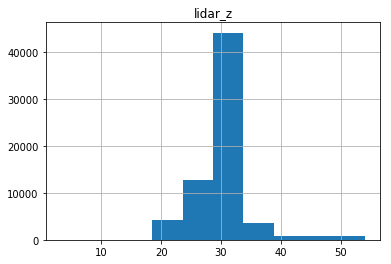

In [13]:
natural_hist_museum_lidar_readings.hist(column='lidar_z')

In [14]:
natural_hist_museum_lidar_readings.describe()

,bldgid,shape_area,altitude_m,shape_length,lidar_z,intensity,classification,gps_time,overlap,scan_angle,synthetic,withheld,dcoctocode
count,67344.0,6.734400e+04,6.734400e+04,6.734400e+04,67344.000000,67344.000000,67344.000000,6.734400e+04,67344.0,67344.000000,67344.0,67344.0,67344.0
mean,75888.0,2.168958e+04,5.361000e+01,8.213005e+02,30.718174,22782.422027,5.991462,2.070110e+08,0.0,0.441183,0.0,0.0,2115.0
std,0.0,1.796811e-08,2.842192e-11,8.584557e-10,4.342667,12849.226988,0.200829,7.572388e-01,0.0,1.547341,0.0,0.0,0.0
min,75888.0,2.168958e+04,5.361000e+01,8.213005e+02,3.240000,0.000000,1.000000,2.070110e+08,0.0,-3.000000,0.0,0.0,2115.0
25%,75888.0,2.168958e+04,5.361000e+01,8.213005e+02,28.640000,13400.000000,6.000000,2.070110e+08,0.0,-1.000000,0.0,0.0,2115.0
50%,75888.0,2.168958e+04,5.361000e+01,8.213005e+02,30.650000,19564.000000,6.000000,2.070110e+08,0.0,0.000000,0.0,0.0,2115.0
75%,75888.0,2.168958e+04,5.361000e+01,8.213005e+02,32.600000,28006.000000,6.000000,2.070110e+08,0.0,2.000000,0.0,0.0,2115.0
max,75888.0,2.168958e+04,5.361000e+01,8.213005e+02,54.080000,65535.000000,6.000000,2.070110e+08,0.0,4.000000,0.0,0.0,2115.0


Looks like for the case of the Smithonian Natural history museum, the building height lines up very well with the max value of lidar readings


Let's also visualize the LIDAR Point cloud to see if makes sense

In [15]:
natural_hist_museum_lidar_points = pd.read_sql_query('''select ST_X(las_grnd_coord ) as las_x, ST_Y(las_grnd_coord) as las_y, lidar_z as las_z from lidarbuildingmatchtest where
    bldgid = 75888''', cnx)

In [16]:
natural_hist_museum_lidar_points
natural_hist_museum_lidar_points.iloc[:, 0].values

array([-77.02658864, -77.02653584, -77.02653031, ..., -77.0258489 ,
       -77.02584383, -77.02585132])

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

Performing a scatter plot of the lidar reading does make it kinda look like a 3/4 view of the museum

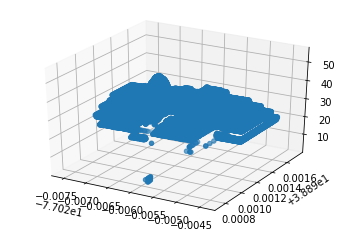

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(natural_hist_museum_lidar_points.iloc[:, 0].values, 
           natural_hist_museum_lidar_points.iloc[:, 1].values, 
           natural_hist_museum_lidar_points.iloc[:, 2].values, 
            marker = 'o'
        )

plt.show()

It looks like just taking a maximum of lidar z reading for a building's points is sufficient to measure the height of large and unobstructed buildings, like large office buildings.  Let's take this thesis and apply it to office buildings in DC 

## Correlate True Building Height and LIDAR Readings for Large Buildings

Assuming that large buildings have a minimum ground area of 1000 sqr meters or 10763. sqr feet.  We will apply the techniques learnt with Smithonian to these buildings

In [19]:
pd.read_sql_query('''select count(*) as count_of_large_buildings from buildinginfotest where
    shape_area >= 1000''', cnx)

,count_of_large_buildings
0,4813


In [20]:
large_buildings_df = pd.read_sql_query('''select id, egid, altitude_m from buildinginfotest where
    shape_area >= 5000''', cnx)
large_buildings_df.describe()

,id,altitude_m
count,481.000000,481.000000
mean,64737.540541,59.595426
std,22064.838177,30.130003
min,1095.000000,7.490000
25%,56132.000000,39.150000
50%,68897.000000,53.780000
75%,77855.000000,70.450000
max,100955.000000,193.350000


In [29]:
large_buildings_df.shape[0]

481

In [35]:
#set a fixed random seed that I can change later
import random
np.random.seed(51)

#get a random building index from the large_buildings_df 
random_idx = random.sample(range(0, large_buildings_df.shape[0]), 10)
random_idx


[263, 313, 177, 75, 70, 154, 36, 194, 310, 108]

In [38]:
large_buildings_random_df = large_buildings_df.iloc[random_idx, :]
large_buildings_random_df

,id,egid,altitude_m
263,69650,DC00006528,57.41
313,72257,DC00006035,54.00
177,65554,DC00044221,38.55
75,42045,DC00016244,156.46
70,39543,DC00015998,73.74
154,62540,DC00063776,58.14
36,27992,DC00027137,105.56
194,66377,DC00000306,62.54
310,72241,DC00005939,53.46
108,54567,DC00026545,51.67


In [45]:
large_buildings_random_blgids = list(large_buildings_random_df["id"].values)
large_buildings_random_blgids

[69650, 72257, 65554, 42045, 39543, 62540, 27992, 66377, 72241, 54567]

In [55]:
sql_string = '''\
select bldgid, egid, ST_X(las_grnd_coord) as las_x, ST_Y(las_grnd_coord), lidar_z as las_z, intensity, classification, gps_time, overlap, scan_angle, synthetic, withheld, dcoctocode
from lidarbuildingmatchtest lidarblg where
lidarblg.bldgid in ({})\
'''.format( ','.join(str(v) for v in large_buildings_random_blgids) )
sql_string
#large_buildings_lidar_readings_df = pd.read_sql_query('''
#select bldgid, egid, ST_X(las_grnd_coord) as las_x, ST_Y(las_grnd_coord), lidar_z as las_z, intensity, classification, gps_time, overlap, scan_angle, synthetic, withheld, dcoctocode
#from lidarbuildingmatchtest lidarblg where
#lidarblg.bldgid in ( 69650, 72257, 65554);
#''', cnx)

'select bldgid, egid, ST_X(las_grnd_coord) as las_x, ST_Y(las_grnd_coord), lidar_z as las_z, intensity, classification, gps_time, overlap, scan_angle, synthetic, withheld, dcoctocode\nfrom lidarbuildingmatchtest lidarblg where\nlidarblg.bldgid in (69650,72257,65554,42045,39543,62540,27992,66377,72241,54567)'

In [56]:
large_buildings_lidar_readings_df = pd.read_sql_query(sql_string, cnx)

In [57]:
#peak at this data
large_buildings_lidar_readings_df.head()

,bldgid,egid,las_x,st_y,las_z,intensity,classification,gps_time,overlap,scan_angle,synthetic,withheld,dcoctocode
0,27992,DC00027137,-77.067269,38.946007,95.72,65535.0,6,2.070101e+08,0.0,3.0,0,0,1623
1,27992,DC00027137,-77.067318,38.946012,95.81,9112.0,6,2.070101e+08,0.0,3.0,0,0,1623
2,27992,DC00027137,-77.067279,38.946005,95.59,30035.0,6,2.070101e+08,0.0,5.0,0,0,1623
3,27992,DC00027137,-77.067273,38.946010,95.80,33842.0,6,2.070101e+08,0.0,5.0,0,0,1623
4,27992,DC00027137,-77.067277,38.946012,95.85,6030.0,6,2.070101e+08,0.0,5.0,0,0,1623


Some additional information on LAS classification code:
0: Created, never classified
1: Unclassified
2: Ground
3: Low vegetation
4: Medium vegetation
5: High vegetation
6: Building
7: Low point (noise)
8: Model key-point (mass point0
9: Water
10: Reserved
11: Reserved
12: Overlap points
13+: Reserved

### Treating (Filtering) the LIDAR points values
Steps: 
1. Filter out all LIDAR points whose classification is not 0, 1, and 6
2. Get the max of the height of LIDAR y reading and compare it against the surveyed height of buildings
3. Compare results

In [42]:
large_buildings_lidar_readings_df.groupby(['bldgid']).max()

,egid,las_x,st_y,las_z,intensity,classification,gps_time,overlap,scan_angle,synthetic,withheld,dcoctocode
bldgid,,,,,,,,,,,,
65554,DC00044221,-77.063211,38.905925,41.73,65535.0,9,2.070120e+08,1.0,10.0,0,0,1717
69650,DC00006528,-77.023117,38.899704,58.01,65535.0,6,2.070106e+08,0.0,2.0,0,0,2116
72257,DC00006035,-77.020068,38.896014,53.73,65535.0,7,2.070106e+08,0.0,4.0,0,0,2216


In [65]:
valid_las_classification_codes = [0, 1, 6]
large_buildings_lidar_readings_filtered_df = \
    large_buildings_lidar_readings_df[large_buildings_lidar_readings_df.classification.isin(
    valid_las_classification_codes)]


In [64]:
large_buildings_lidar_readings_filtered_df['classification'].unique()

array([6, 1])

In [68]:
large_buildings_lidar_readings_filtered_df[["bldgid", "egid", "las_z", "classification"]].groupby(['bldgid']).max()

,egid,las_z,classification
bldgid,,,
27992,DC00027137,105.45,6
39543,DC00015998,74.00,6
42045,DC00016244,160.69,6
54567,DC00026545,54.26,6
62540,DC00063776,59.04,6
65554,DC00044221,40.16,6
66377,DC00000306,63.04,6
69650,DC00006528,58.01,6
72241,DC00005939,55.08,6


In [ ]:
large_buildings_result = large_buildings_lidar_readings_filtered_df['bldgid'].corr